# Polygenic Risk Score (PRS) Pipeline for Height  


## 1  Context – What are we trying to do?

We will use the European genomic data to estimate the height PRS using the PGS score data.

## 2  Learning objectives
By the end of this exercise you should be able to:
1. Download and harmonise public **PGS Catalog** scoring files.
2. Calculate individual‑level **polygenic risk scores** (PRS).
3. Test PRS–phenotype associations with covariate adjustment.


## 3  Environment setup and data preparation

In [1]:
# shared tools and data folder
source /home/student/USER/miniconda.sh
conda activate anders
TOOL_PATH=/home/student/opt/anders # for standalone tool script including java package
SHARED_PATH=/home/tch_wyd/myname/shared # For reference database


(base) (anders) (anders) (anders) 


In [2]:
mkdir -p ~/sysu_day6_PRS

cd ~/sysu_day6_PRS

cp -sf /home/tch_myname/heritability_data/European_1w_QC.white.bed ./
cp -sf /home/tch_myname/heritability_data/European_1w_QC.white.fam ./
cp -sf /home/tch_myname/heritability_data/European_1w_phenotypes.white.txt ./

## We will use PRS data of
# Height PRS (PGS002332)
# IGF‑1 PRS (PGS001960)
# Birth‑weight PRS (PGS003494)
cp -sf /home/tch_myname/PRS_data/PGS*.txt.gz ./

which plink
ls .

(anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) /home/student/miniconda3/envs/anders/bin/plink
(anders) European_1w_phenotypes.white.txt  PGS002332.harmon_snp.bed
European_1w_QC.white.bed          PGS002332.harmon_snp.bim
European_1w_QC.white.bim          PGS002332.harmon_snp.fam
European_1w_QC.white.fam          PGS002332.harmon_snp.log
PGS001960.harmonized.tsv          PGS002332.pgs_merged.tsv
PGS001960.harmon_score.log        PGS002332.snp.list
PGS001960.harmon_score.profile    PGS002332.txt.gz
PGS001960.harmon_snp.bed          PGS003494.harmonized.tsv
PGS001960.harmon_snp.bim          PGS003494.harmon_score.log
PGS001960.harmon_snp.fam          PGS003494.harmon_score.profile
PGS001960.harmon_snp.log          PGS003494.harmon_snp.bed
PGS001960.pgs_merged.tsv          PGS003494.harmon_snp.bim
PGS001960.snp.list                PGS003494.harmon_snp.fam
PGS001960.txt.gz                  PGS003494.harmon_snp.lo

In [3]:
# rename BIM SNP ID

awk -F "\t" '{print $1"\t"$1"_"$4"\t"$3"\t"$4"\t"$5"\t"$6}' /home/tch_myname/heritability_data/European_1w_QC.white.bim >./European_1w_QC.white.bim


(anders) (anders) (anders) 


In [4]:
# set up R working space
work_d <- path.expand("~/sysu_day6_PRS")
setwd(work_d)

# Import some functions to help in visualization
source("/home/tch_wyd/myname/shared/visFuns.R")
source("/home/tch_wyd/myname/shared/newPlotPlink.R")
source("/home/tch_wyd/myname/shared/online.R")

### The effect sizes used to calculate the polygenetic scores

We have downloaded effect sizes for each SNP from the PGS cataglog for 3 phenotypes from 3 studies:


go to the website https://www.pgscatalog.org/ and find out which studies and which traits. There ID is
 - PGS002332
 - PGS001960
 - PGS003494

You should be able to see which population the PGS recipe has been train on. 


## 4 Harmonize the PGS data


We will use the genotypes from the 10K UKbiobank indiviudals what we use for GWAS (day 3) and heritability (day5). We will calculate the PGS for these indivudals and therefore we will have to make sure that the SNP information downloaded from the PGS catalog is compatible with the SNP data in our 10K UKbiobank indiviudals 


In [5]:
# Height PRS (PGS002332)
# IGF‑1 PRS (PGS001960)
# Birth‑weight PRS (PGS003494)


# bim file for our data
bimfile <- setNames(read.table("European_1w_QC.white.bim", header=FALSE), c("CHR", "ID", "POS", "COORD", "ALLELE_1", "ALLELE_2"))

## PGS recipe from PGS catalog
#read and print number of SNPs in PGS catalog effect sizes
nrow( pgsfile_PGS002332 <- read.table("PGS002332.txt.gz", header=TRUE) )
nrow( pgsfile_PGS001960 <- read.table("PGS001960.txt.gz", header=TRUE) )
nrow( pgsfile_PGS003494 <- read.table("PGS003494.txt.gz", header=TRUE) )

pgsfile_PGS002332$id <- paste(pgsfile_PGS002332$chr_name, pgsfile_PGS002332$chr_position, sep="_")
pgsfile_PGS001960$id <- paste(pgsfile_PGS001960$chr_name, pgsfile_PGS001960$chr_position, sep="_")
pgsfile_PGS003494$id <- paste(pgsfile_PGS003494$chr_name, pgsfile_PGS003494$chr_position, sep="_")

rownames(pgsfile_PGS002332) <- pgsfile_PGS002332$id
rownames(pgsfile_PGS001960) <- pgsfile_PGS001960$id
rownames(pgsfile_PGS003494) <- pgsfile_PGS003494$id

rownames(bimfile) <- bimfile$ID
pgsfile_PGS001960$rsID <- NULL

[1] 1109311

[1] 87149

[1] 979739

Lets we how many SNPs overlap between our SNPs and the SNP from the PGS catalog

In [6]:
# overlap between our data and PGS catalog

length( com_id_PGS002332 <- intersect(pgsfile_PGS002332$id, bimfile$ID) )
length( com_id_PGS001960 <- intersect(pgsfile_PGS001960$id, bimfile$ID) )
length( com_id_PGS003494 <- intersect(pgsfile_PGS003494$id, bimfile$ID) )


[1] 99132

[1] 11171

[1] 86453

 - Approximate what fraction of SNPs overlap?

Our UKbiobank data is not imputed and we only have ~700K SNPs. This is why the overlap is so low. This will affect our abilty to predict the phenotypes and the PGS will work less well compare to having imputed data. 

Lets look inside the download effect sizes from PGS catalog

In [7]:
head(pgsfile_PGS003494[com_id_PGS003494,],20)

,chr_name,chr_position,effect_allele,other_allele,effect_weight,id
,<int>,<int>,<chr>,<chr>,<dbl>,<chr>
1_838555,1,838555,A,C,3.361021e-06,1_838555
1_888659,1,888659,T,C,1.814995e-05,1_888659
1_918573,1,918573,A,G,-2.136879e-06,1_918573
1_1005806,1,1005806,T,C,4.703642e-06,1_1005806
1_1018704,1,1018704,A,G,-1.126199e-05,1_1018704
1_1031540,1,1031540,A,G,9.357709e-06,1_1031540
1_1062638,1,1062638,C,A,8.084242e-06,1_1062638
1_1110019,1,1110019,G,A,1.028631e-04,1_1110019
1_1152631,1,1152631,A,C,5.693845e-05,1_1152631


- Which column has the effect size used for PGS calculation: $PGS_i=\sum_j g_{ij}\beta_j$ ?


Below we will harmonize the data so that the two alleles (effect_alleles, other_alleles) match with our data from UKbiobank


In [8]:
for (pgs_id in c("PGS002332", "PGS001960", "PGS003494")){
pgsfile <- get(paste0("pgsfile_", pgs_id))
comid <- get(paste0("com_id_", pgs_id))
keep <- pgsfile[comid, "effect_allele"] == bimfile[comid, "ALLELE_1"] & pgsfile[comid, "other_allele"] == bimfile[comid, "ALLELE_2"]
switch <- pgsfile[comid, "effect_allele"] == bimfile[comid, "ALLELE_2"] & pgsfile[comid, "other_allele"] == bimfile[comid, "ALLELE_1"]
tmp_switch <- setNames(pgsfile[comid, ][switch, c(1, 2, 4, 3, 5, 6)], colnames(pgsfile))
tmp_switch[, 5] <- -tmp_switch[, 5]

pgs_new <- rbind(pgsfile[comid, ][keep, ], tmp_switch)
write.table(pgs_new, paste0("./", pgs_id, ".harmonized.tsv"), sep="\t", row=FALSE, col=FALSE, quote=FALSE)
write.table(pgs_new$id, paste0("./", pgs_id, ".snp.list"), , sep="\t", row=FALSE, col=FALSE, quote=FALSE)
}



The new file with the harmonized effect sizes are called "harmozied.tzv" 

## 5. Calculate the PRS score

We will use plink to perform the calculation
$$PGS_i=\sum_j g_{ij}\beta_j$$

where $\beta$ comes from the PGS catalog and $g_{ij}$ is the genotypes found in our 10K ukbiobank samples. For each individuals $i$ we get one score. 

In [9]:
## takes < 1 min. 


## PGS002332
#extract overlapping SNPs
plink --bfile European_1w_QC.white --extract PGS002332.snp.list --make-bed --keep-allele-order --out PGS002332.harmon_snp 
#calculate PGS
plink --bfile PGS002332.harmon_snp --score ./PGS002332.harmonized.tsv 6 3 5 header sum --out ./PGS002332.harmon_score

## PGS001960
plink --bfile European_1w_QC.white --extract PGS001960.snp.list --make-bed --keep-allele-order --out PGS001960.harmon_snp 
plink --bfile PGS001960.harmon_snp --score ./PGS001960.harmonized.tsv 6 3 5 header sum --out ./PGS001960.harmon_score

## PGS003494
plink --bfile European_1w_QC.white --extract PGS003494.snp.list --make-bed --keep-allele-order --out PGS003494.harmon_snp 
plink --bfile PGS003494.harmon_snp --score ./PGS003494.harmonized.tsv 6 3 5 header sum --out ./PGS003494.harmon_score


(anders) (anders) (anders) (anders) (anders) PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to PGS002332.harmon_snp.log.
Options in effect:
  --bfile European_1w_QC.white
  --extract PGS002332.snp.list
  --keep-allele-order
  --make-bed
  --out PGS002332.harmon_snp

515181 MB RAM detected; reserving 257590 MB for main workspace.
Allocated 193192 MB successfully, after larger attempt(s) failed.
272081 variants loaded from .bim file.
7489 people (3312 males, 4177 females) loaded from .fam.
7489 phenotype values loaded from .fam.
--extract: 99123 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 7489 founders and 0 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate is 0.995869.
99123 variants and 7489 people pass filters and QC.
Phenotype data is quantitative.
--make-bed to PGS002332.ha

We calculated 3 scores for each indiviudals. The file containing the score for PGS003494 (birthweight) can be seen here. The last column containts the PGS

In [10]:
head PGS003494.harmon_score.profile

      FID       IID  PHENO    CNT   CNT2 SCORESUM
  1001118   1001118   1.61 172722  43716 -0.0213068
  1002621   1002621    1.5 172360  43572 0.0116389
  1003258   1003258   1.64 170870  43026 -0.00748836
  1004181   1004181   1.76 172660  43529 -0.0242858
  1004240   1004240   1.62 172492  43633 -0.0505324
  1004285   1004285   1.66 172652  43554 -0.0504555
  1006840   1006840    1.7 172150  43743 -0.0326599
  1007533   1007533  1.667 172664  43810 -0.0403769
  1007571   1007571   1.74 172254  43342 0.0308867
(anders) 


## 6. PRS estimation and visualization

First we will load some function to read and  merge the PGS scores with our observed phenotypes. Remember that we have measuments for height and BMI for our UKbiobank indiviudals. 

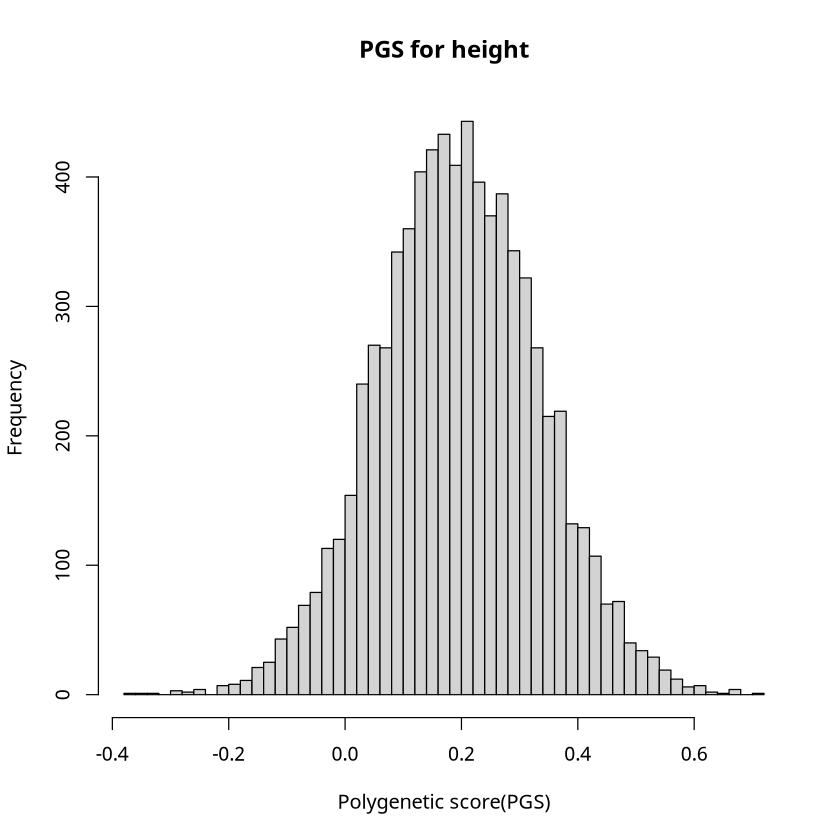

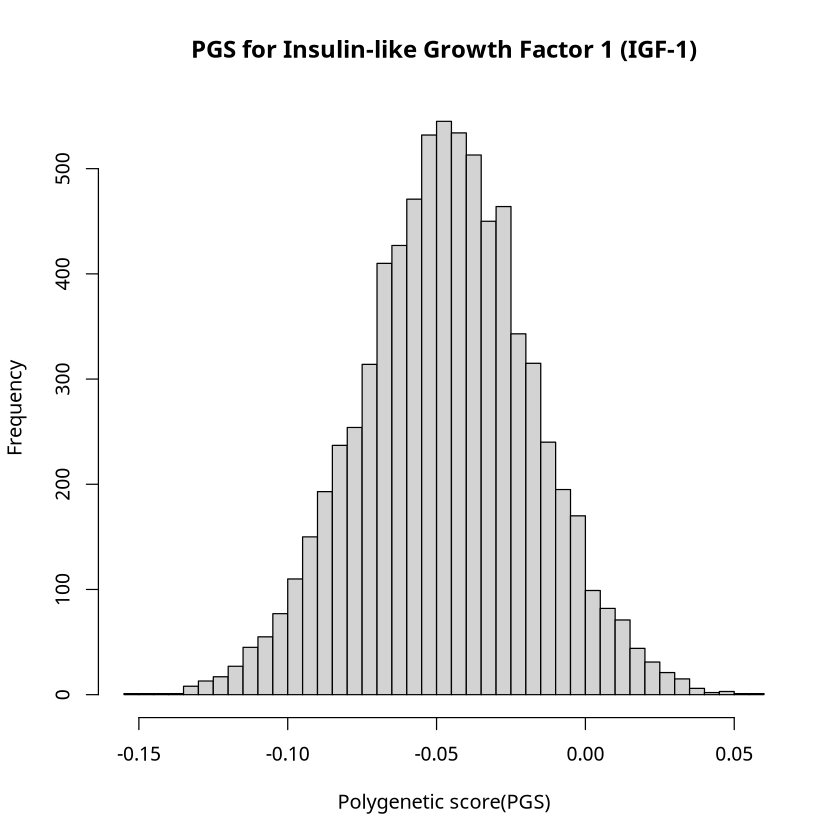

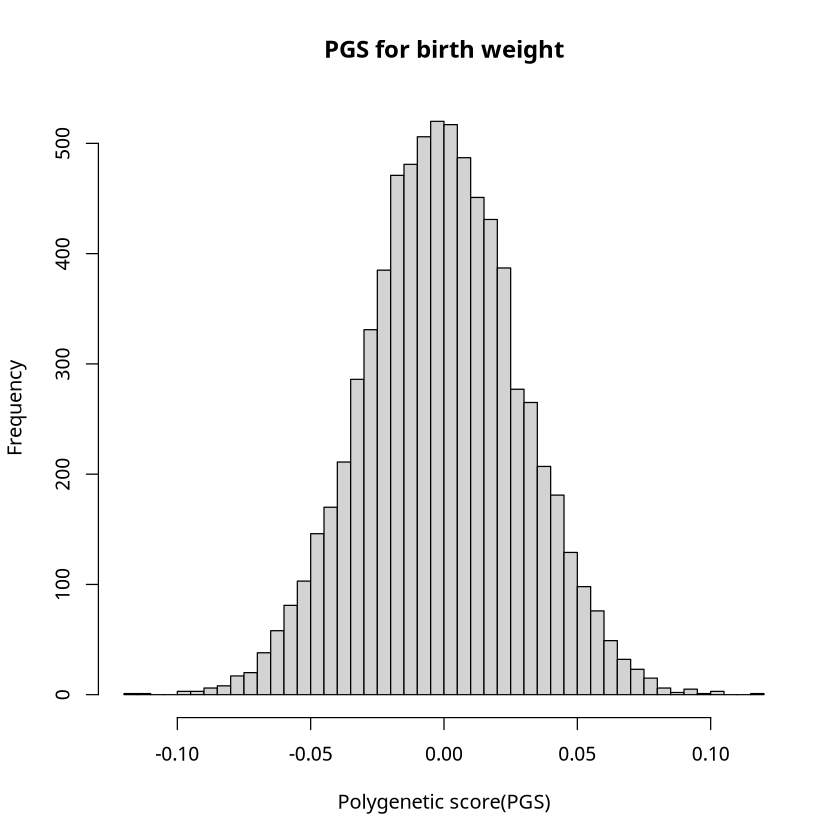

In [11]:
# Height PRS (PGS002332)
# IGF‑1 PRS (PGS001960)
# Birth‑weight PRS (PGS003494)

#pheno_ori <- read.table("./European_1w_phenotypes.white.txt", sep="\t", header=TRUE, stringsAsFactors=FALSE)
#rownames(pheno_ori) <- pheno_ori$eid
CI_calculation <- function(beta, se, interval=0.95){
    # return value: (CI low, CI high)
    one_side <- (1-0.95)/2
    return(c(beta-qnorm(one_side,lower.tail = F)*se, beta+qnorm(one_side,lower.tail = F)*se))
}
read_pgs <- function(pgs_id){
    #pgs_id <- "PGS002332"
    pheno_ori <- read.table("./European_1w_phenotypes.white.txt", sep="\t", header=TRUE, stringsAsFactors=FALSE)
    rownames(pheno_ori) <- pheno_ori$eid
    prs_df <- read.table(paste0("./", pgs_id, ".harmon_score.profile"), header=TRUE, stringsAsFactors=FALSE)
    rownames(prs_df) <- prs_df$eid
    pheno_fam <- setNames(read.table(paste0("./", pgs_id, ".harmon_snp.fam")), c("FID", "IID", "Father_IID", "Mother_IID", "SEX", "Phenotype_height"))
    rownames(pheno_fam) <- pheno_fam$IID
    
    #igf_prs_df <- read.table("./prs/PGS001960.profile", header=TRUE, stringsAsFactors=FALSE)
    #bw_prs_df <- read.table("./prs/PGS003494.profile", header=TRUE, stringsAsFactors=FALSE)
    
    prs_merged <- cbind(
        prs_df[, c("IID", "SCORESUM")], 
        pheno_ori[match(prs_df$IID, pheno_ori$eid), c("Body_mass_index"), drop=FALSE], 
        pheno_fam[match(prs_df$IID, pheno_fam$IID), c("SEX", "Phenotype_height")]
    )
    write.table(prs_merged, paste0("./", pgs_id, ".pgs_merged.tsv"), sep="\t", quote=FALSE, row.names=FALSE, col.names=TRUE)
    prs_merged
}

normalize_score <- function(x){
    x <- x-mean(x)
    x <- x/sd(x)
}

pgs_height <- read_pgs("PGS002332")
pgs_igf <- read_pgs("PGS001960")
pgs_bw <- read_pgs("PGS003494")
hist(pgs_height$SCORESUM,xlab="Polygenetic score(PGS)",main="PGS for height",br=50)
hist(pgs_igf$SCORESUM,xlab="Polygenetic score(PGS)",main="PGS for Insulin-like Growth Factor 1 (IGF-1)",br=50)
hist(pgs_bw$SCORESUM,xlab="Polygenetic score(PGS)",main="PGS for birth weight",br=50)

The distribution of score all look like a normal distribution. 
 - why?

Let plot the PGS vs. our obsered BMI and height measurments

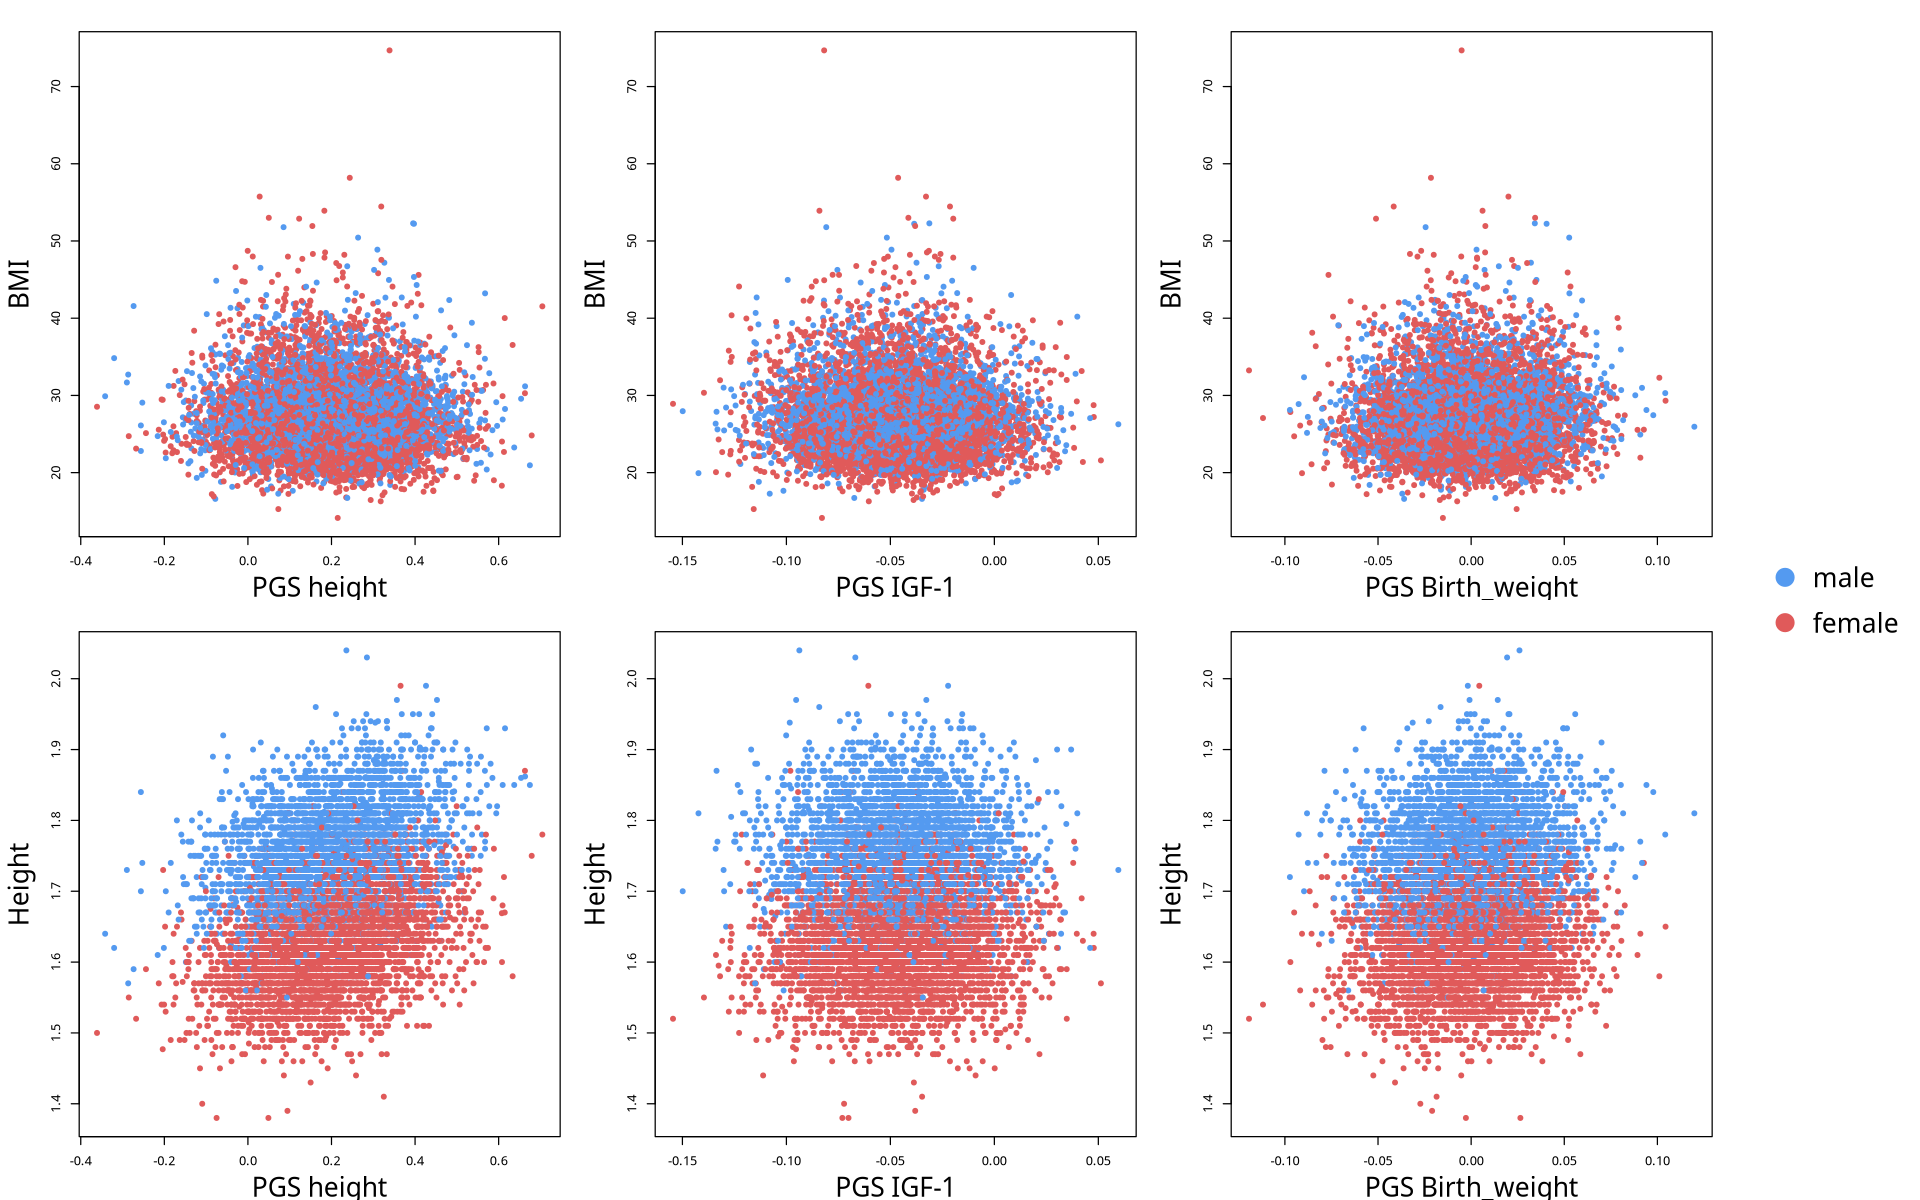

In [12]:
options(repr.plot.width=16, repr.plot.height=10)

layout(matrix(c(1,2,3,4,5,6,7,4), nrow=2, byrow=TRUE), widths=c(3,3,3,1))

par(mar=c(4,5, 2, 1), mgp=c(3,1,0))
plot(pgs_height$SCORESUM, pgs_height$Body_mass_index, col=c("#549af0", "#e05a5a")[pgs_height$SEX], pch=19, cex=0.8, xlab="PGS height", ylab="BMI", cex.lab=2)

par(mar=c(4,5, 2, 1), mgp=c(3,1,0))
plot(pgs_igf$SCORESUM, pgs_igf$Body_mass_index, col=c("#549af0", "#e05a5a")[pgs_height$SEX], pch=19, cex=0.8, xlab="PGS IGF-1", ylab="BMI", cex.lab=2)

par(mar=c(4,5, 2, 1), mgp=c(3,1,0))
plot(pgs_bw$SCORESUM, pgs_bw$Body_mass_index, col=c("#549af0", "#e05a5a")[pgs_height$SEX], pch=19, cex=0.8, xlab="PGS Birth_weight", ylab="BMI", cex.lab=2)

par(mar=c(0.1,0.1,0.1,0.1))
plot(0,0,col="transparent", axes=F, bty="n")
legend("left", legend=c("male", "female"), col=c("#549af0", "#e05a5a"), cex=2, pt.cex=3, pch=19, bty="n", x.intersp=0.5, xpd=TRUE)

par(mar=c(4,5, 2, 1), mgp=c(3,1,0))
plot(pgs_height$SCORESUM, pgs_height$Phenotype_height, col=c("#549af0", "#e05a5a")[pgs_height$SEX], pch=19, cex=0.8, xlab="PGS height", ylab="Height", cex.lab=2)

par(mar=c(4,5, 2, 1), mgp=c(3,1,0))
plot(pgs_igf$SCORESUM, pgs_igf$Phenotype_height, col=c("#549af0", "#e05a5a")[pgs_height$SEX], pch=19, cex=0.8, xlab="PGS IGF-1", ylab="Height", cex.lab=2)

par(mar=c(4,5, 2, 1), mgp=c(3,1,0))
plot(pgs_bw$SCORESUM, pgs_bw$Phenotype_height, col=c("#549af0", "#e05a5a")[pgs_height$SEX], pch=19, cex=0.8, xlab="PGS Birth_weight", ylab="Height", cex.lab=2)


 - Which PGS looks the most correlated with our measurement?

The correlation is not very large. Therefore it will be easier to see of we stratefy our individuals into 10 groups based on their PGS. This is shown here for height

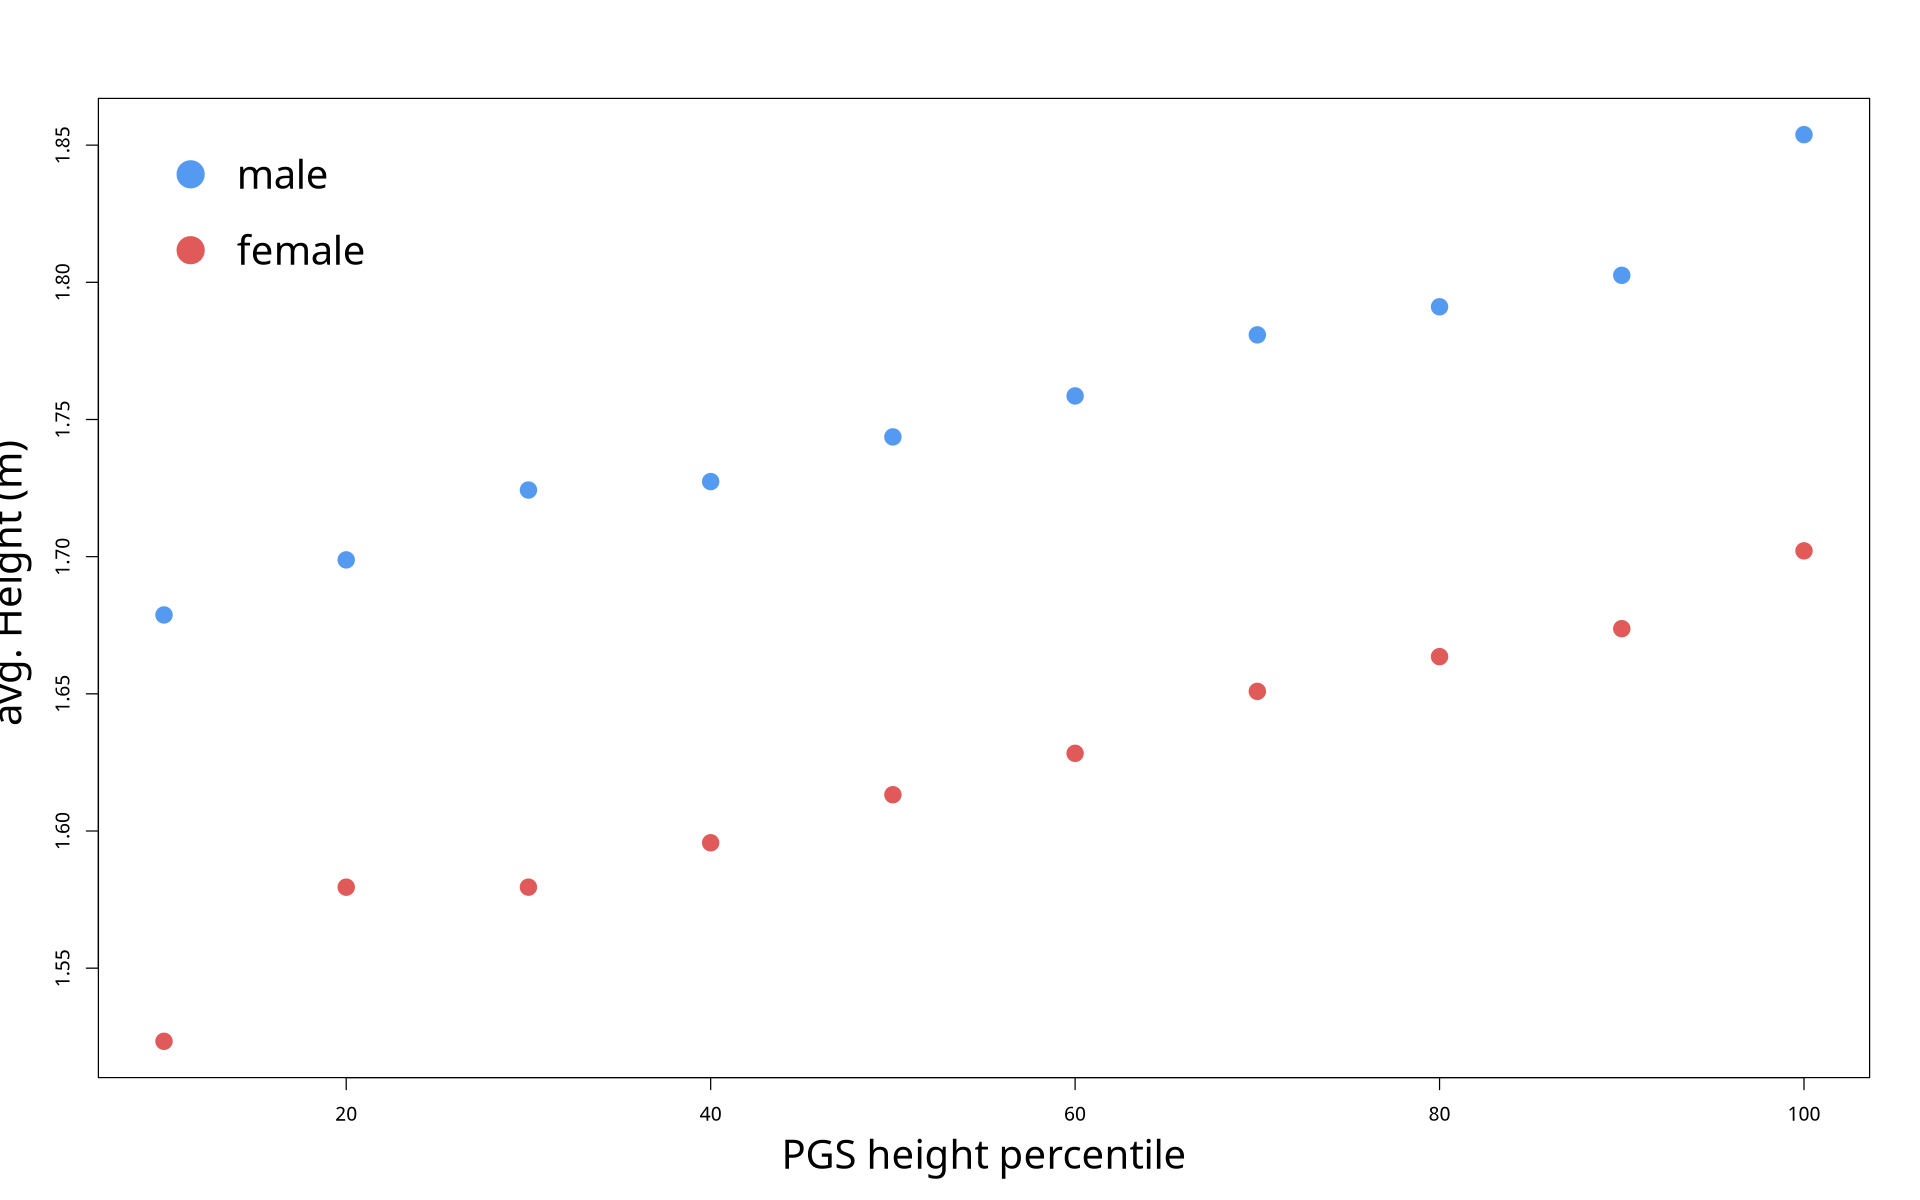

In [13]:
## convert score to a prediction of height

cutter <- function(pheno, score,sex,br=10){
    s <- sex==sex[1]
    cc <- cut(score[s], breaks=br)
    cc2 <- cut(score[!s], breaks=br) 
    m <- tapply(pheno[s], cc, mean,na.rm=T)
    m2 <- tapply(pheno[!s], cc2, mean,na.rm=T)
    list(y=c(m,m2),x=c(1:br,1:br),sex=rep(1:2,each=br))
}

res <- cutter(pgs_height$Phenotype_height,pgs_height$SCORESUM, pgs_height$SEX)




plot(res$x*10,res$y, col=c("#549af0", "#e05a5a")[res$sex], pch=19, cex=1.8, xlab="PGS height percentile", ylab=" avg. Height (m)", cex.lab=2)
legend("topleft", legend=c("male", "female"), col=c("#549af0", "#e05a5a"), cex=2, pt.cex=3, pch=19, bty="n", x.intersp=0.5, xpd=TRUE)




We can convert our PGS score into a prediction using linear regression

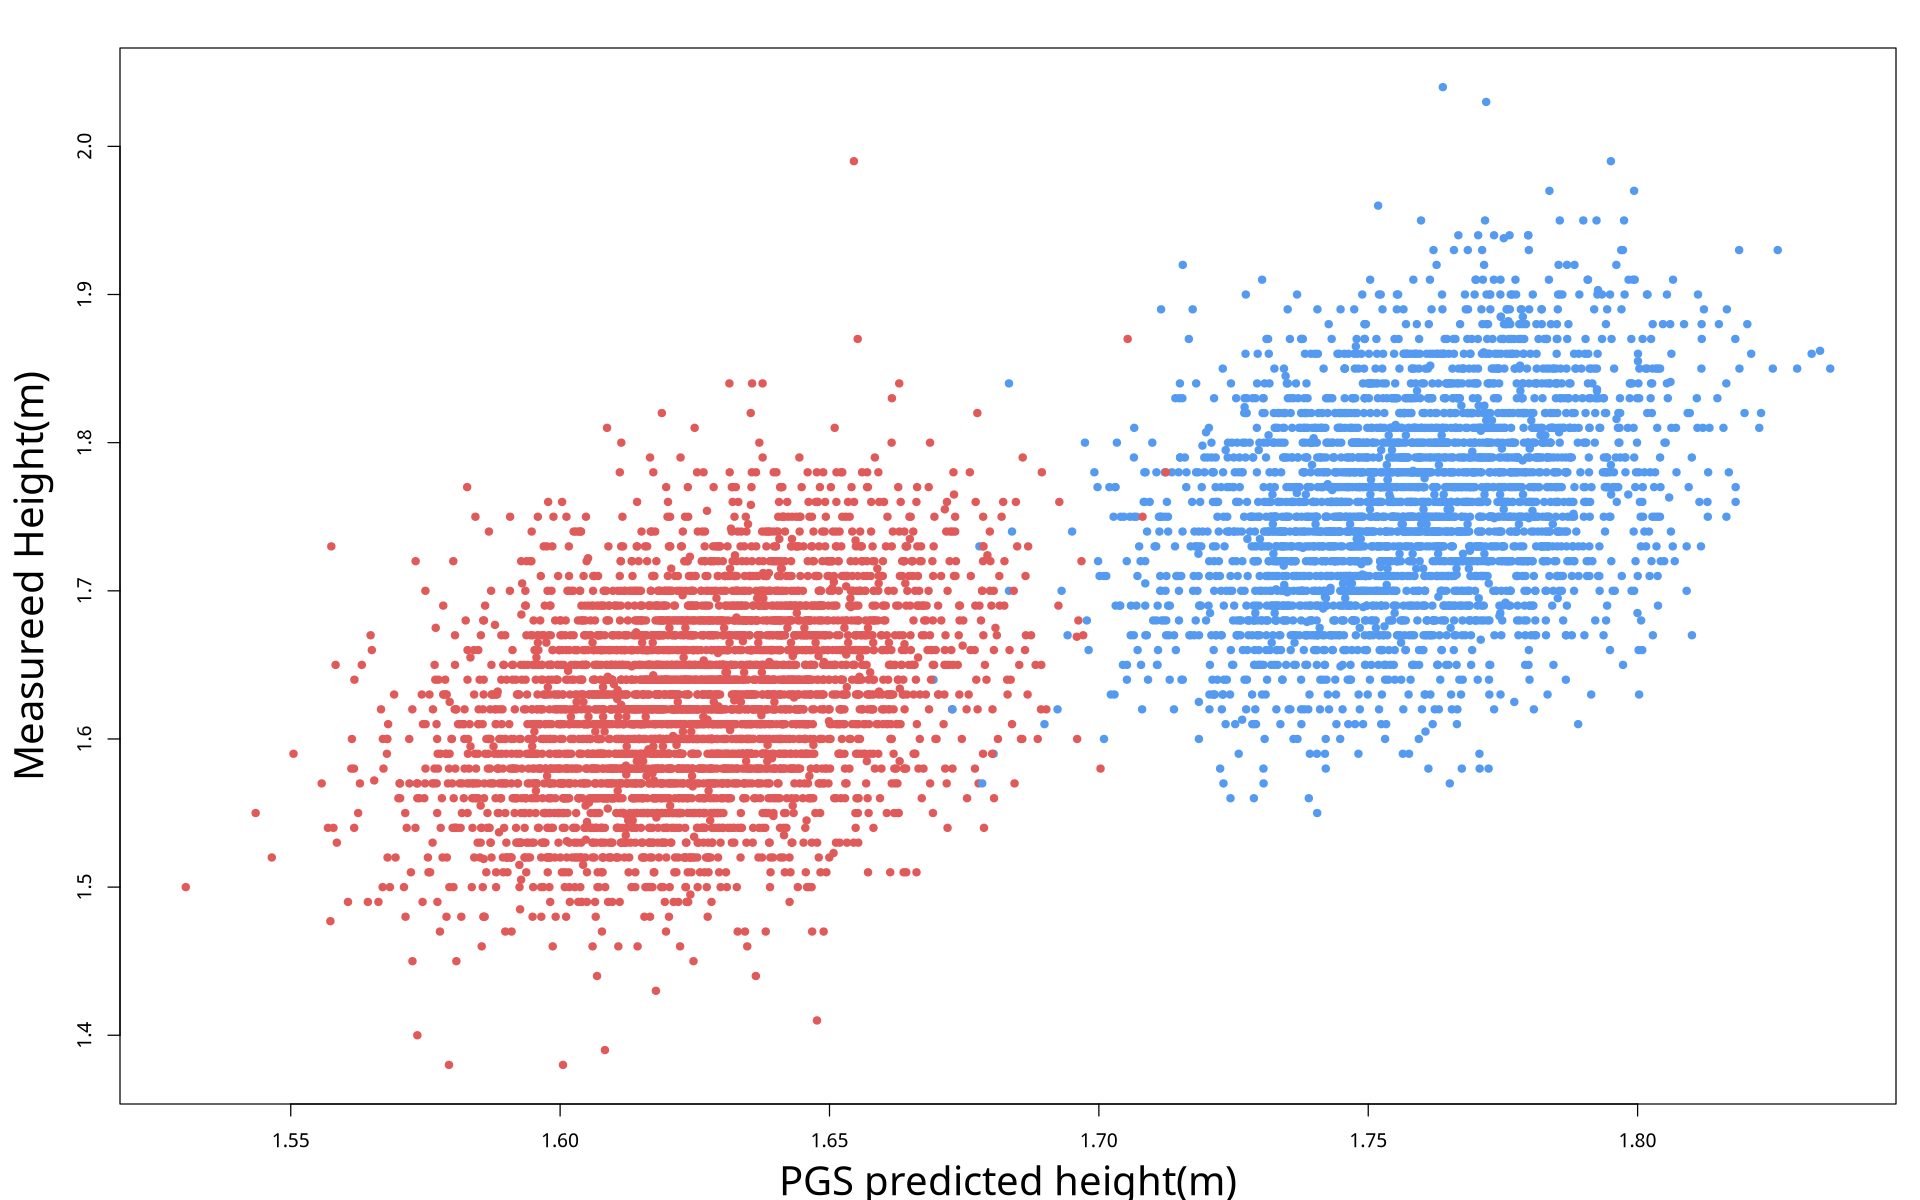

In [14]:
PGSprediction <- lm(pgs_height$Phenotype_height~pgs_height$SCORESUM*pgs_height$SEX)

par(mar=c(4,5, 2, 1), mgp=c(3,1,0))
plot(PGSprediction$fitted.value, pgs_height$Phenotype_height, col=c("#549af0", "#e05a5a")[pgs_height$SEX], pch=19, cex=0.8, xlab="PGS predicted height(m)", ylab="Measureed Height(m)", cex.lab=2)


 - How does this differ from the plot with the raw PGS scores?

### Testing for causal links

Lets try to test if there is a causal link between the phenotypes used to create the scores and the measure BMI and height. 

In [15]:
prs_est_all <- cbind(PRS=c("BMI ~ prs_height","BMI ~ prs_IGF1", "BMI ~ prs_Birth_weight", "Height ~ prs_height","Height ~ prs_IGF1", "Height ~ prs_Birth_weight"), setNames(as.data.frame(rbind(
summary(lm(pgs_height$Body_mass_index ~ normalize_score(pgs_height$SCORESUM) + pgs_height$SEX))$coefficients[2,],
summary(lm(pgs_igf$Body_mass_index ~ normalize_score(pgs_igf$SCORESUM) + pgs_igf$SEX))$coefficients[2,] ,
summary(lm(pgs_bw$Body_mass_index ~ normalize_score(pgs_bw$SCORESUM) + pgs_bw$SEX))$coefficients[2,],
summary(lm(pgs_height$Phenotype_height ~ normalize_score(pgs_height$SCORESUM) + pgs_height$SEX))$coefficients[2,],
summary(lm(pgs_igf$Phenotype_height ~ normalize_score(pgs_igf$SCORESUM) + pgs_igf$SEX))$coefficients[2,] ,
summary(lm(pgs_bw$Phenotype_height ~ normalize_score(pgs_bw$SCORESUM) + pgs_bw$SEX))$coefficients[2,])),
c("beta", "se", "t.val", "pval")))

prs_est_all <- cbind(prs_est_all, setNames(
    as.data.frame(t(
        apply(prs_est_all[, c("beta", "se")], 1, function(x){CI_calculation(x[1], x[2])})
    )), 
      c("ci_low", "ci_high")))
rownames(prs_est_all) <- prs_est_all$PRS


The results can be see here. 
The measurement is shown on the left side of the ~ and the score on the right. e.g. for BMI ~ prs_height we are testing whether the predicted height (The PGS scores for height) has an effect on BMI.

In [16]:
prs_est_all

,PRS,beta,se,t.val,pval,ci_low,ci_high
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BMI ~ prs_height,BMI ~ prs_height,-0.109753134,0.0555776224,-1.974772,4.833071e-02,-0.2186832726,-0.0008229961
BMI ~ prs_IGF1,BMI ~ prs_IGF1,-0.116235879,0.0555727448,-2.091599,3.650805e-02,-0.2251564572,-0.0073153007
BMI ~ prs_Birth_weight,BMI ~ prs_Birth_weight,0.152350941,0.0555671381,2.741745,6.125887e-03,0.0434413514,0.2612605304
Height ~ prs_height,Height ~ prs_height,0.023230815,0.0007096401,32.736054,8.507761e-220,0.0218399461,0.0246216840
Height ~ prs_IGF1,Height ~ prs_IGF1,0.002194545,0.0007582690,2.894152,3.812827e-03,0.0007083654,0.0036807251
Height ~ prs_Birth_weight,Height ~ prs_Birth_weight,0.007693584,0.0007535473,10.209822,2.584987e-24,0.0062166584,0.0091705095


## 7. Visualization of effects


Lets plot the effects of the predicted phenotypes (PGS) on the measured phenotypes.  Let start with the effect on height

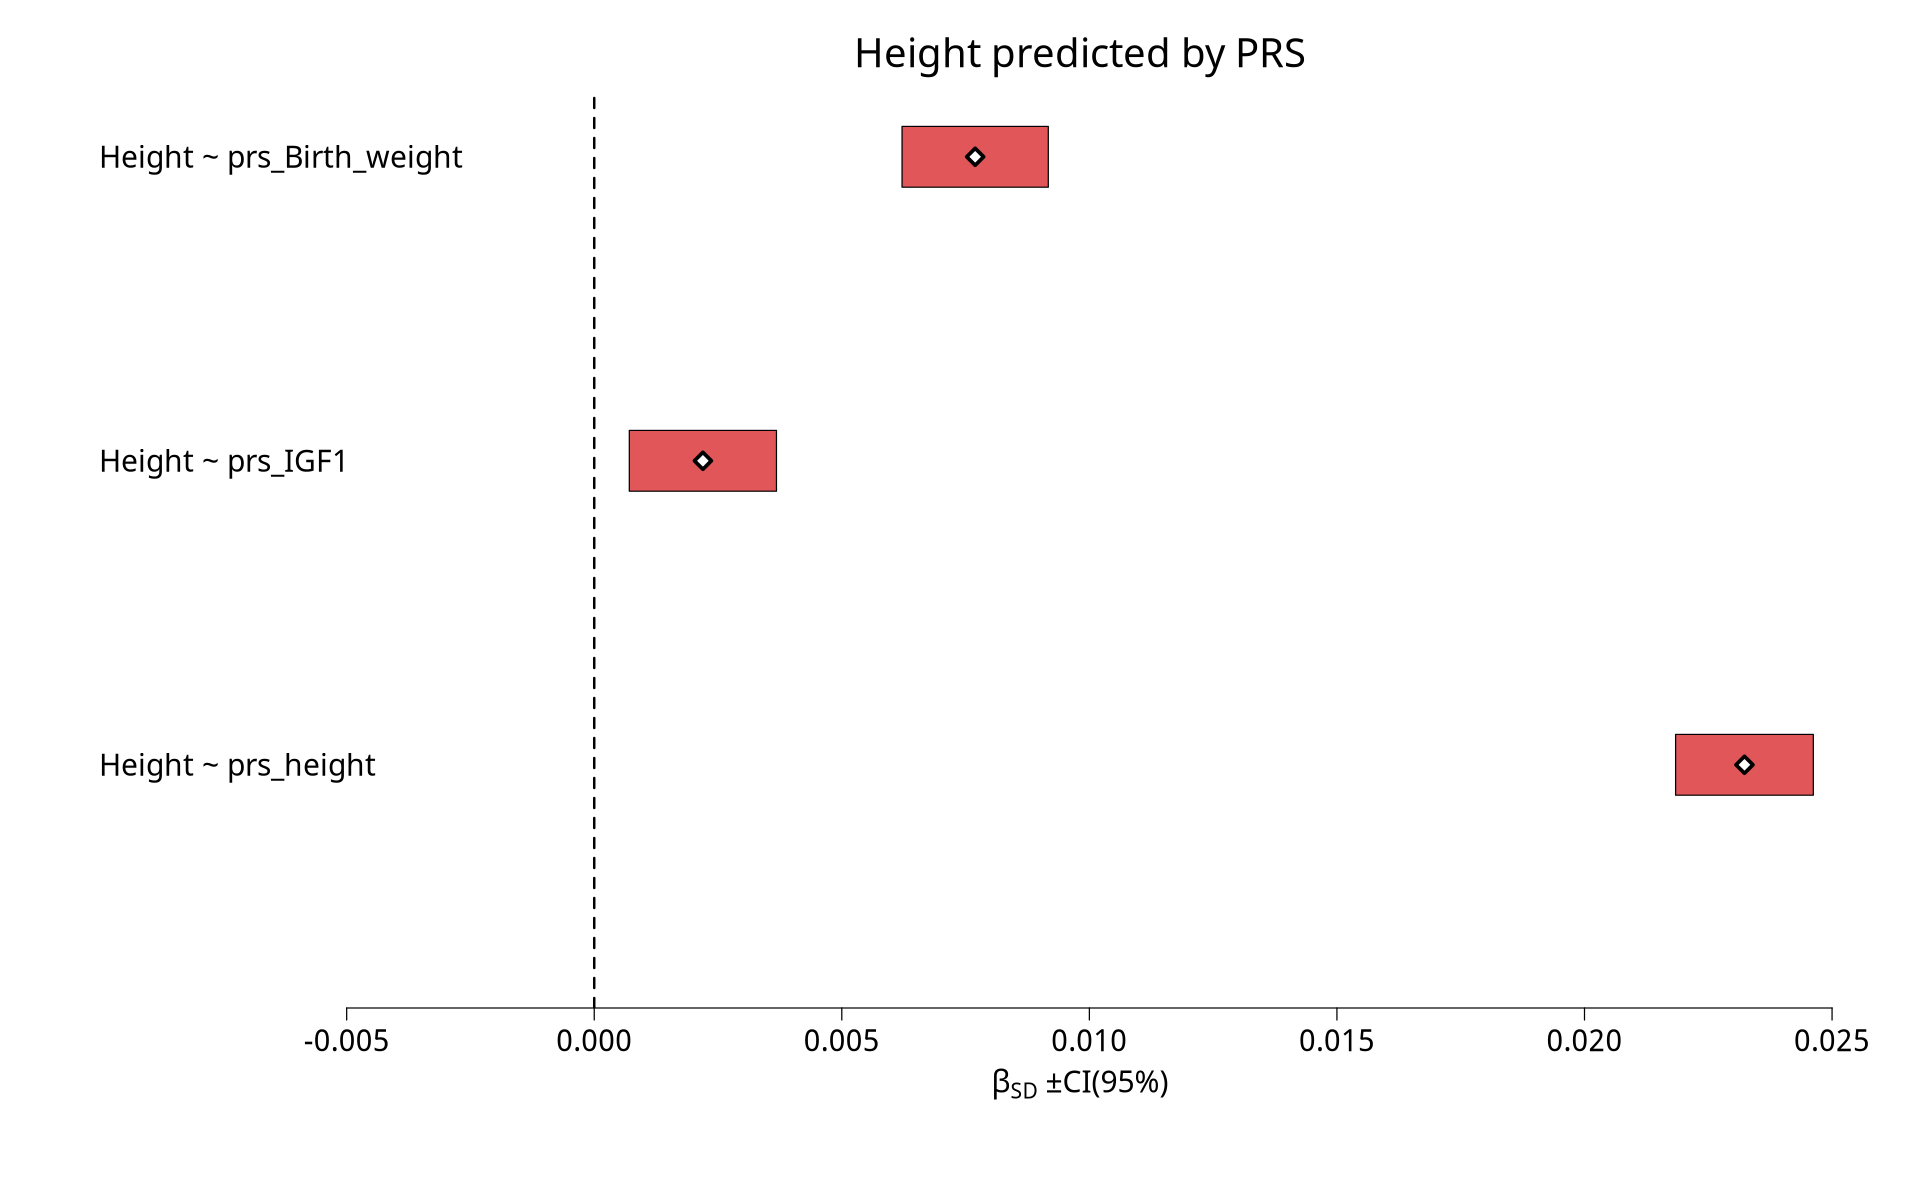

In [17]:
prs_height <- prs_est_all[4:6, ]
par(mar=c(8, 12, 4, 2), mgp=c(2,1,0))
xrange <- range(c(prs_height$ci_low, prs_height$ci_high, 0, -0.005))
plot(1,1, col="transparent", xlim=xrange, ylim=c(0.2, nrow(prs_height)+0.2), ylab="", xlab="", yaxs="i", bty="n", yaxt="n", cex.axis=1.5)
abline(v=0, lty=2, lwd=2)
rect_h <- 0.2
rect(prs_height$ci_low, 1:nrow(prs_height)-0.5*rect_h, prs_height$ci_high, 1:nrow(prs_height)+0.5*rect_h, col="#e15759")

points(prs_height$beta, 1:nrow(prs_height)+0*rect_h, pch=23, cex=1.5, bg="white", col="black", lwd=3)
text(xrange[1]-0.005, 1:nrow(prs_height), labels=prs_height$PRS, adj=c(0, 0.5), cex=1.5, xpd=TRUE)
tmp_lab <- "±CI(95%)"
text(median(xrange), -0.05, labels=bquote(beta[SD] ~ .(tmp_lab)), adj=c(0.5, 0.5), cex=1.5, xpd=TRUE)
mtext("Height predicted by PRS", line=1, cex=2, adj=0.5)


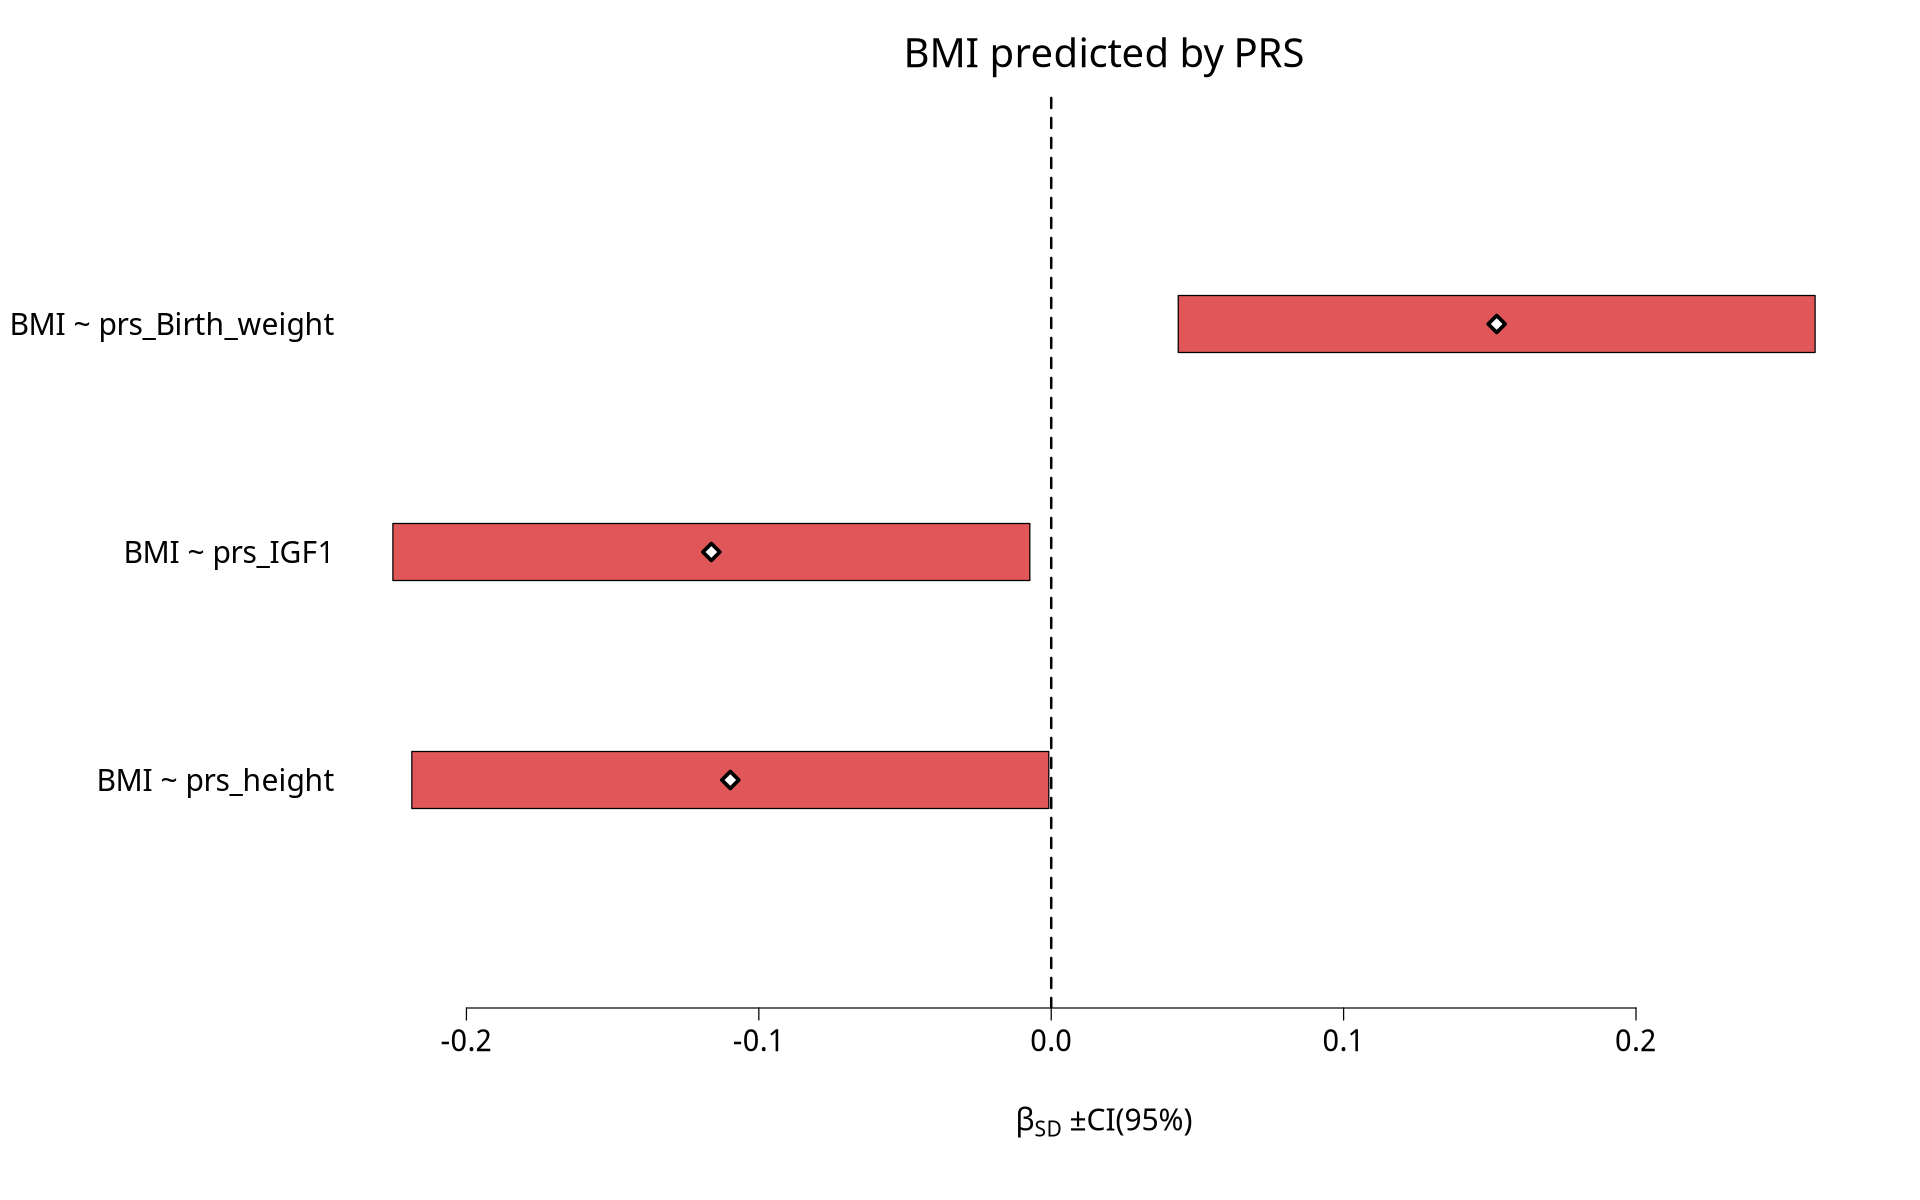

In [18]:
prs_bmi <- prs_est_all[1:3, ]
par(mar=c(8, 14, 4, 2), mgp=c(2,1,0))
xrange <- range(c(prs_bmi$ci_low, prs_bmi$ci_high))
plot(1,1, col="transparent", xlim=xrange, ylim=c(0, nrow(prs_bmi)+1), ylab="", xlab="", yaxs="i", bty="n", yaxt="n", cex.axis=1.5)
abline(v=0, lty=2, lwd=2)
rect_h <- 0.25
rect(prs_bmi$ci_low, 1:nrow(prs_bmi)-0.5*rect_h, prs_bmi$ci_high, 1:nrow(prs_bmi)+0.5*rect_h, col="#e15759")

points(prs_bmi$beta, 1:nrow(prs_bmi)+0*rect_h, pch=23, cex=1.5, bg="white", col="black", lwd=3)
text(xrange[1]-0.02, 1:nrow(prs_bmi), labels=prs_bmi$PRS, adj=c(1, 0.5), cex=1.5, xpd=TRUE)
tmp_lab <- "±CI(95%)"
text(median(xrange), -0.5, labels=bquote(beta[SD] ~ .(tmp_lab)), adj=c(0.5, 0.5), cex=1.5, xpd=TRUE)
mtext("BMI predicted by PRS", line=1, cex=2, adj=0.5)


 - try to explain why IGF and height have a negative effect on  BMI?

## References & further reading
* PLINK 2 documentation – https://www.cog-genomics.org/plink/2.0/  
* Lambert et al. (2022) *The Polygenic Score Catalog as an open resource*  
* Visscher et al. (2017) *10 Years of GWAS discovery*  
* Choi et al. (2020) *Tutorial: Polygenic scores.* Nat Rev Genet.